# Feature Analysis & Effects of Regularization

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from itertools import chain, combinations
from sklearn.linear_model import Lasso, Ridge
from sklearn.datasets import load_diabetes
import statsmodels.api as sm
from altair import  Chart

## Functions

In [2]:
def generate_coeffs(alphas, estimator, X_train, y_train):
    params = []
    
    for alpha in alphas:
        estimator.set_params(alpha=alpha)
        estimator.fit(X_train, y_train)
        
        weights = estimator.coef_
        test_error = estimator.score(X_train, y_train)
        
        params.append(weights)
             
    params = pd.DataFrame(params)
    params.columns = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
   
    params = params.stack().reset_index()
    params.columns = ['Index', 'Feature', 'Weight']
    
    alphas = np.log10(alphas)
    params['Alpha'] = params.apply(lambda row: alphas[row['Index']] / alphas[0], axis=1)
    params.drop('Index', 1, inplace=True)
    
    
    return params

## Feature Analysis

In [3]:
X_train, y_train = load_diabetes(return_X_y=True)
correlation_matrix = np.corrcoef(X_train, rowvar=0)

with pd.option_context('display.max_rows', 10, 'display.max_columns', 10, 'expand_frame_repr', False):
    print(pd.DataFrame(correlation_matrix))

          0         1         2         3         4         5         6         7         8         9
0  1.000000  0.173737  0.185085  0.335427  0.260061  0.219243 -0.075181  0.203841  0.270777  0.301731
1  0.173737  1.000000  0.088161  0.241013  0.035277  0.142637 -0.379090  0.332115  0.149918  0.208133
2  0.185085  0.088161  1.000000  0.395415  0.249777  0.261170 -0.366811  0.413807  0.446159  0.388680
3  0.335427  0.241013  0.395415  1.000000  0.242470  0.185558 -0.178761  0.257653  0.393478  0.390429
4  0.260061  0.035277  0.249777  0.242470  1.000000  0.896663  0.051519  0.542207  0.515501  0.325717
5  0.219243  0.142637  0.261170  0.185558  0.896663  1.000000 -0.196455  0.659817  0.318353  0.290600
6 -0.075181 -0.379090 -0.366811 -0.178761  0.051519 -0.196455  1.000000 -0.738493 -0.398577 -0.273697
7  0.203841  0.332115  0.413807  0.257653  0.542207  0.659817 -0.738493  1.000000  0.617857  0.417212
8  0.270777  0.149918  0.446159  0.393478  0.515501  0.318353 -0.398577  0.617857 

In [4]:
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()

coefficients = results.params
errors = results.bse
scores = np.divide(coefficients, errors)
ols_test_err = results.mse_total

table_2 = pd.DataFrame({'Weight':coefficients, 'Std. Error':errors, 'Z Score':scores})
print(table_2)

    Std. Error      Weight   Z Score
0   179.966522  -10.012198 -0.055634
1   184.403641 -239.819089 -1.300512
2   200.401287  519.839787  2.593994
3   197.053051  324.390428  1.646209
4  1255.065752 -792.184162 -0.631189
5  1021.183140  476.745838  0.466856
6   640.155181  101.044570  0.157844
7   486.369921  177.064176  0.364052
8   517.774425  751.279321  1.450978
9   198.746629   67.625386  0.340259


## Best Subset of Features

In [5]:
best_error = 1e30
xs = list(range(10))
powerset = chain.from_iterable(combinations(xs,n) for n in range(1, len(xs)+1))

for subset in powerset:
    model = sm.OLS(y_train, X_train[:, subset])
    results = model.fit()

    coefficients = results.params
    std_errors = results.bse
    test_error = results.mse_total
    
    if test_error < best_error:
        best_subset = subset
        best_error = test_error
        best_coeffs = coefficients
        best_std_err = std_errors
        
print(best_subset)

(0,)


## Effects of L1 & L2 Regularizations

In [6]:
alphas = np.logspace(-5, 2, num=1500)

ridge = generate_coeffs(alphas, Ridge(), X_train, y_train)
lasso = generate_coeffs(alphas, Lasso(), X_train, y_train)

### Lasso

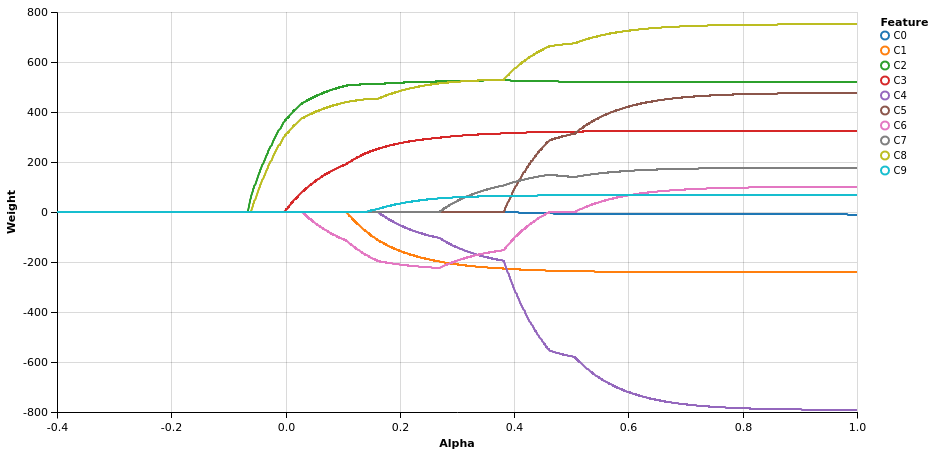

In [7]:
chart = Chart(lasso).mark_line().encode(x='Alpha:Q', y='Weight:Q', color='Feature:N')
chart.configure_cell(height=400, width=800)

### Ridge

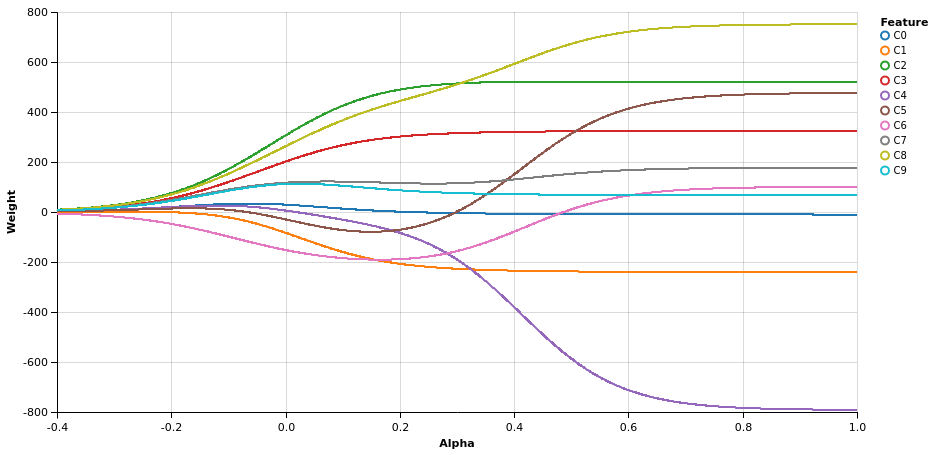

In [8]:
chart = Chart(ridge).mark_line().encode(x='Alpha:Q', y='Weight:Q', color='Feature:N')
chart.configure_cell(height=400, width=800)